# Final Project Submission

Please fill out:
* Student name: Ben Atkin
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL:


The goal: Create a model that best predicts house price in the King's County dataset

# Setup notebook

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.api as sm
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.preprocessing import scale
from scipy.stats import zscore
from ipyleaflet import Map, GeoData, basemaps, LayersControl, Choropleth
import geopandas
import json
from ipywidgets import Text, HTML
from ipyleaflet import WidgetControl, GeoJSON 
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
%matplotlib inline


def get_dataframes(regex='.*'):
    """Find all dataframes in global namespace
    
    Excludes stored Jupyter output
    Returns dict with key: value as df_name: df
    """
    dataframe_dict = {}
    for k in globals().keys():
        if (isinstance(eval(k), pd.core.frame.DataFrame) 
            and not k.startswith('_') 
            and re.search(regex, k)):
            dataframe_dict[k] = eval(k)
    return dataframe_dict

def print_df_stats(df_dict,
                   head=True,
                   describe=True, 
                   value_counts=True):
    """Print .info(), .head(), .describe() for dataframes

    use get_dataframes() to get df_dict
    """
    for name, df in df_dict.items():
        print('=' * 100)
        print(name)
        print(df.info(), '\n')
        if head:
            print(df.head(), '\n')
        if describe:
            print(df.describe(include='all'), '\n\n')
        if value_counts:
            for col in df.columns:
                print(f'Value counts for {col}:')
                print(df[col].value_counts(), '\n')
                
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Import the data

Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors

* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [2]:
df = pd.read_csv('kc_house_data.csv')

# Investigating data

In [3]:
print_df_stats(get_dataframes('df'))

df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB
None 

  

Name: grade, dtype: int64 

Value counts for sqft_above:
1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2601      1
440       1
2473      1
2441      1
1975      1
Name: sqft_above, Length: 942, dtype: int64 

Value counts for sqft_basement:
0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
225.0         1
784.0         1
2120.0        1
2490.0        1
1770.0        1
Name: sqft_basement, Length: 304, dtype: int64 

Value counts for yr_built:
2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64 

Value counts for yr_renovated:
0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64 

Value counts for zipcode:
98103    602
98038    589

scatter requires x column to be numeric -- col: date
scatter requires x column to be numeric -- col: sqft_basement


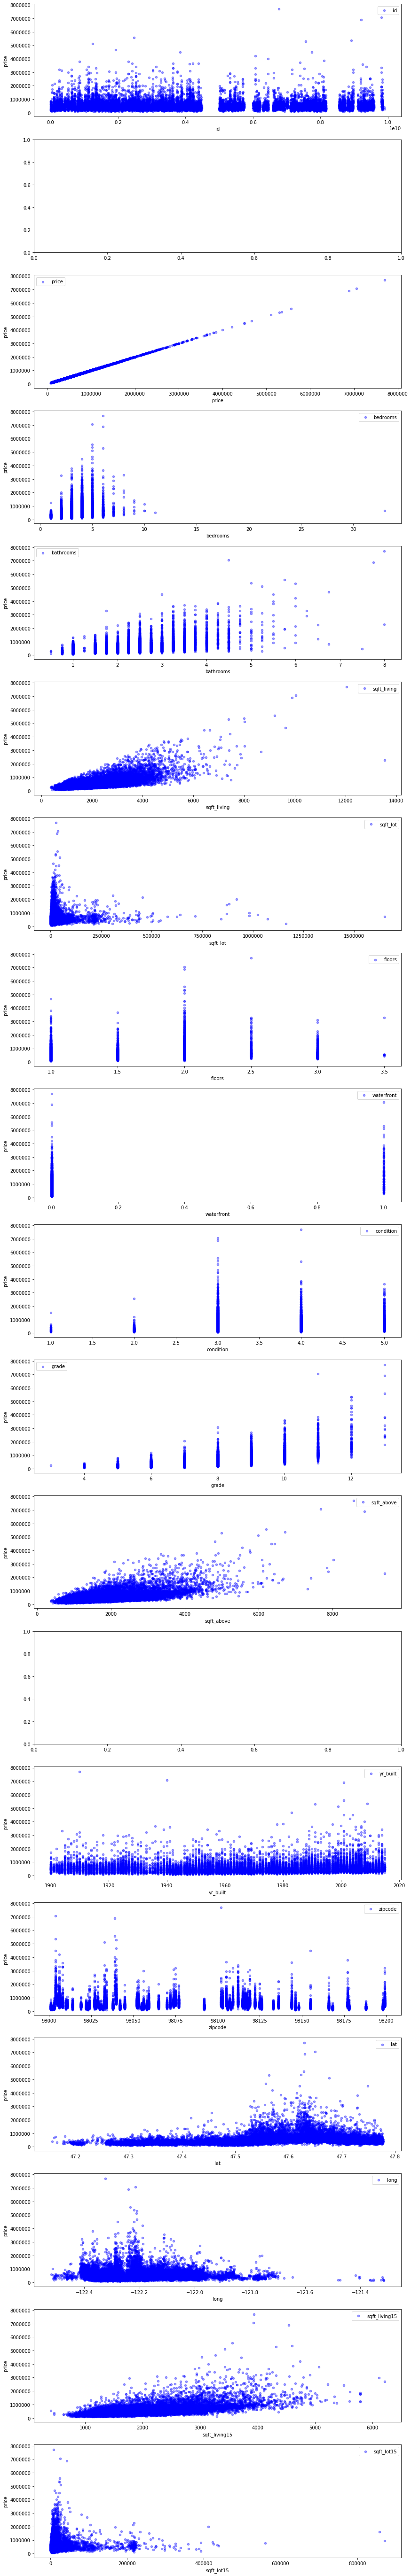

In [4]:
# Investigating which features are categorical, have outliers
cols = ['id', 
        'date', 
        'price', 
        'bedrooms', 
        'bathrooms', 
        'sqft_living',
        'sqft_lot', 
        'floors', 
        'waterfront', 
        'condition', 
        'grade', 
        'sqft_above',
        'sqft_basement', 
        'yr_built', 
        'zipcode', 
        'lat', 
        'long',
        'sqft_living15',
       'sqft_lot15'
       ]

fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(14,100))
for col, ax in zip(cols, axes):
    try:
        df.plot(kind='scatter', x=col, y='price', ax=ax, alpha=0.4, color='b', label=col)
    except ValueError as e:
        print(f'{e} -- col: {col}')
        pass

Looking at the graphs above, the following columns have outliers:

1. bedrooms,
2. bathrooms,
3. sqft_living,
4. sqft_lot,
5. sqft_above,
6. sqft_living15,
7. sqft_lot15

The following columns appear categorical:

1. condition
2. grade
3. zipcode

# Cleaning data

In [5]:
# Missing values
df.view.fillna(0, inplace=True)
df.yr_renovated.fillna(0, inplace=True)
df.waterfront.fillna(0, inplace=True)
sqft_basement_mean = df.sqft_basement.loc[df.sqft_basement != '?'].astype('float').mean()
df.sqft_basement.replace('?', sqft_basement_mean, inplace=True)

# Incorrect dtypes
df.date = pd.to_datetime(df.date)
df.price = df.price.astype('int64')
df.waterfront = df.waterfront.astype('int64')
df.sqft_basement = df.sqft_basement.astype('float').astype('int64')
df.view.astype('int64')

# Convert to binary column
df['has_basement'] = df.sqft_basement.map(lambda x: 1 if x > 0 else 0)
df['renovated'] = df.yr_renovated.map(lambda x: 1 if x > 0 else 0)

# Drop unused or already transformed columns
df.drop(['id', 'date', 'sqft_basement', 'yr_renovated'], axis=1, inplace=True);


# Remove outliers

In [6]:
outlier_cols = [
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'sqft_above',
    'sqft_living15',
    'sqft_lot15'
]

for col in outlier_cols:
    df.drop(df.loc[zscore(df[col]) > 3].index, axis=0, inplace=True)

# Deal with categorical variables, including dealing with multicollinearity

Before converting categorical variables, save a copy of the clean dataframe to be used for mapping the zipcodes.

In [7]:
map_df = df

Which features are categorical? From the above graphs in Investigating Data:
* condition
* grade
* zipcode

Features that I'll treat as categorical in a later iteration perhaps because they're arguably continuous.
* floors
* bedrooms
* bathrooms



In [26]:
# Change dtype of categorical columns, this was causing issues when inputting data to sm.OLS()
    # df.zipcode = df.zipcode.astype('category')
    # df.condition = df.condition.astype('category')
    # df.grade = df.grade.astype('category')

# Binning categorical variables
df.grade = pd.cut(df.grade, list(range(0, 16, 3)), labels=False)

# One-hot encoding other variables and dropping first column for dummy trap
df = pd.concat([df.drop('zipcode', axis=1), pd.get_dummies(df['zipcode'], drop_first=True)], axis=1)
    # df = pd.concat([df.drop('condition', axis=1), pd.get_dummies(df['condition'], drop_first=True)], axis=1)
    # df = pd.concat([df.drop('grade', axis=1), pd.get_dummies(df['grade'], drop_first=True)], axis=1)

# Get a baseline model with all features

In [27]:
y = df.price
X = df.iloc[:, 1:]
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                              4800.
Date:                Mon, 16 Mar 2020   Prob (F-statistic):                        0.00
Time:                        16:53:48   Log-Likelihood:                     -2.6549e+05
No. Observations:               20196   AIC:                                  5.311e+05
Df Residuals:                   20110   BIC:                                  5.318e+05
Df Model:                          86                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.721e+04   1344.477    -12.803      0.000   -1.98e+04   -1.46e+04
bathrooms      1.923e+04   2218.509      8.668      0.000    1.49e+04    2.36e+04
sqft_living     106.8251      4.166     25.640      0.000      98.659     114.991
sqft_lot          1.1478      0.146      7.857      0.000       0.861       1.434
floors        -2.058e+04   2601.720     -7.911      0.000   -2.57e+04   -1.55e+04
waterfront      5.33e+05   1.36e+04     39.331      0.000    5.06e+05     5.6e+05
view           5.967e+04   1474.730     40.463      0.000    5.68e+04    6.26e+04
condition      2.835e+04   1532.662     18.500      0.000    2.54e+04    3.14e+04
grade          5.236e+04   2836.047     18.463      0.000    4.68e+04    5.79e+04
sqft_above       73.1312      4.531     16.140      0.000      64.250      82.012
yr_built       -214.6388     50.517     -4.249      0.000    -313.656    -115.622
lat            1.134e+04   4.83e+04      0.235      0.814   -8.34e+04    1.06e+05
long           3253.3485   1.87e+04      0.174      0.862   -3.34e+04    3.99e+04
sqft_living15    42.3786      2.533     16.728      0.000      37.413      47.344
sqft_lot15       -0.5439      0.218     -2.498      0.012      -0.971      -0.117
has_basement  -1372.8922   3257.743     -0.421      0.673   -7758.335    5012.550
renovated       4.85e+04   5154.807      9.408      0.000    3.84e+04    5.86e+04
98002          2.091e+04   1.11e+04      1.877      0.061    -928.971    4.28e+04
98003          3150.3771      1e+04      0.315      0.753   -1.65e+04    2.28e+04
98004          6.834e+05   1.91e+04     35.834      0.000    6.46e+05    7.21e+05
98005          3.367e+05   2.04e+04     16.498      0.000    2.97e+05    3.77e+05
98006          2.806e+05    1.7e+04     16.506      0.000    2.47e+05    3.14e+05
98007          2.671e+05   2.11e+04     12.650      0.000    2.26e+05    3.08e+05
98008          2.577e+05   2.03e+04     12.706      0.000    2.18e+05    2.97e+05
98010          8.209e+04   1.67e+04      4.909      0.000    4.93e+04    1.15e+05
98011          1.356e+05   2.55e+04      5.322      0.000    8.56e+04    1.86e+05
98014          1.166e+05   3.01e+04      3.874      0.000    5.76e+04    1.76e+05
98019          7.741e+04    2.9e+04      2.665      0.008    2.05e+04    1.34e+05
98022         -9392.1020   1.14e+04     -0.824      0.410   -3.17e+04    1.29e+04
98023         -1.125e+04   8853.764     -1.270      0.204   -2.86e+04    6105.706
98024          1.555e+05   2.81e+04      5.543      0.000    1.01e+05    2.11e+05
98027          2.003e+05   1.75e+04     11.424      0.000    1.66e+05    2.35e+05
98028          1.284e+05   2.42e+04      5.318      0.000    8.11e+04    1.76e+05
98029          2.372e+05   1.97e

# Log transform features

Which features need to be log transformed? Code below displays a histogram of the unchanged feature v.s. the log-transformed version to be able to quickly compare if a log-transformation will make the data appear more normally distributed.

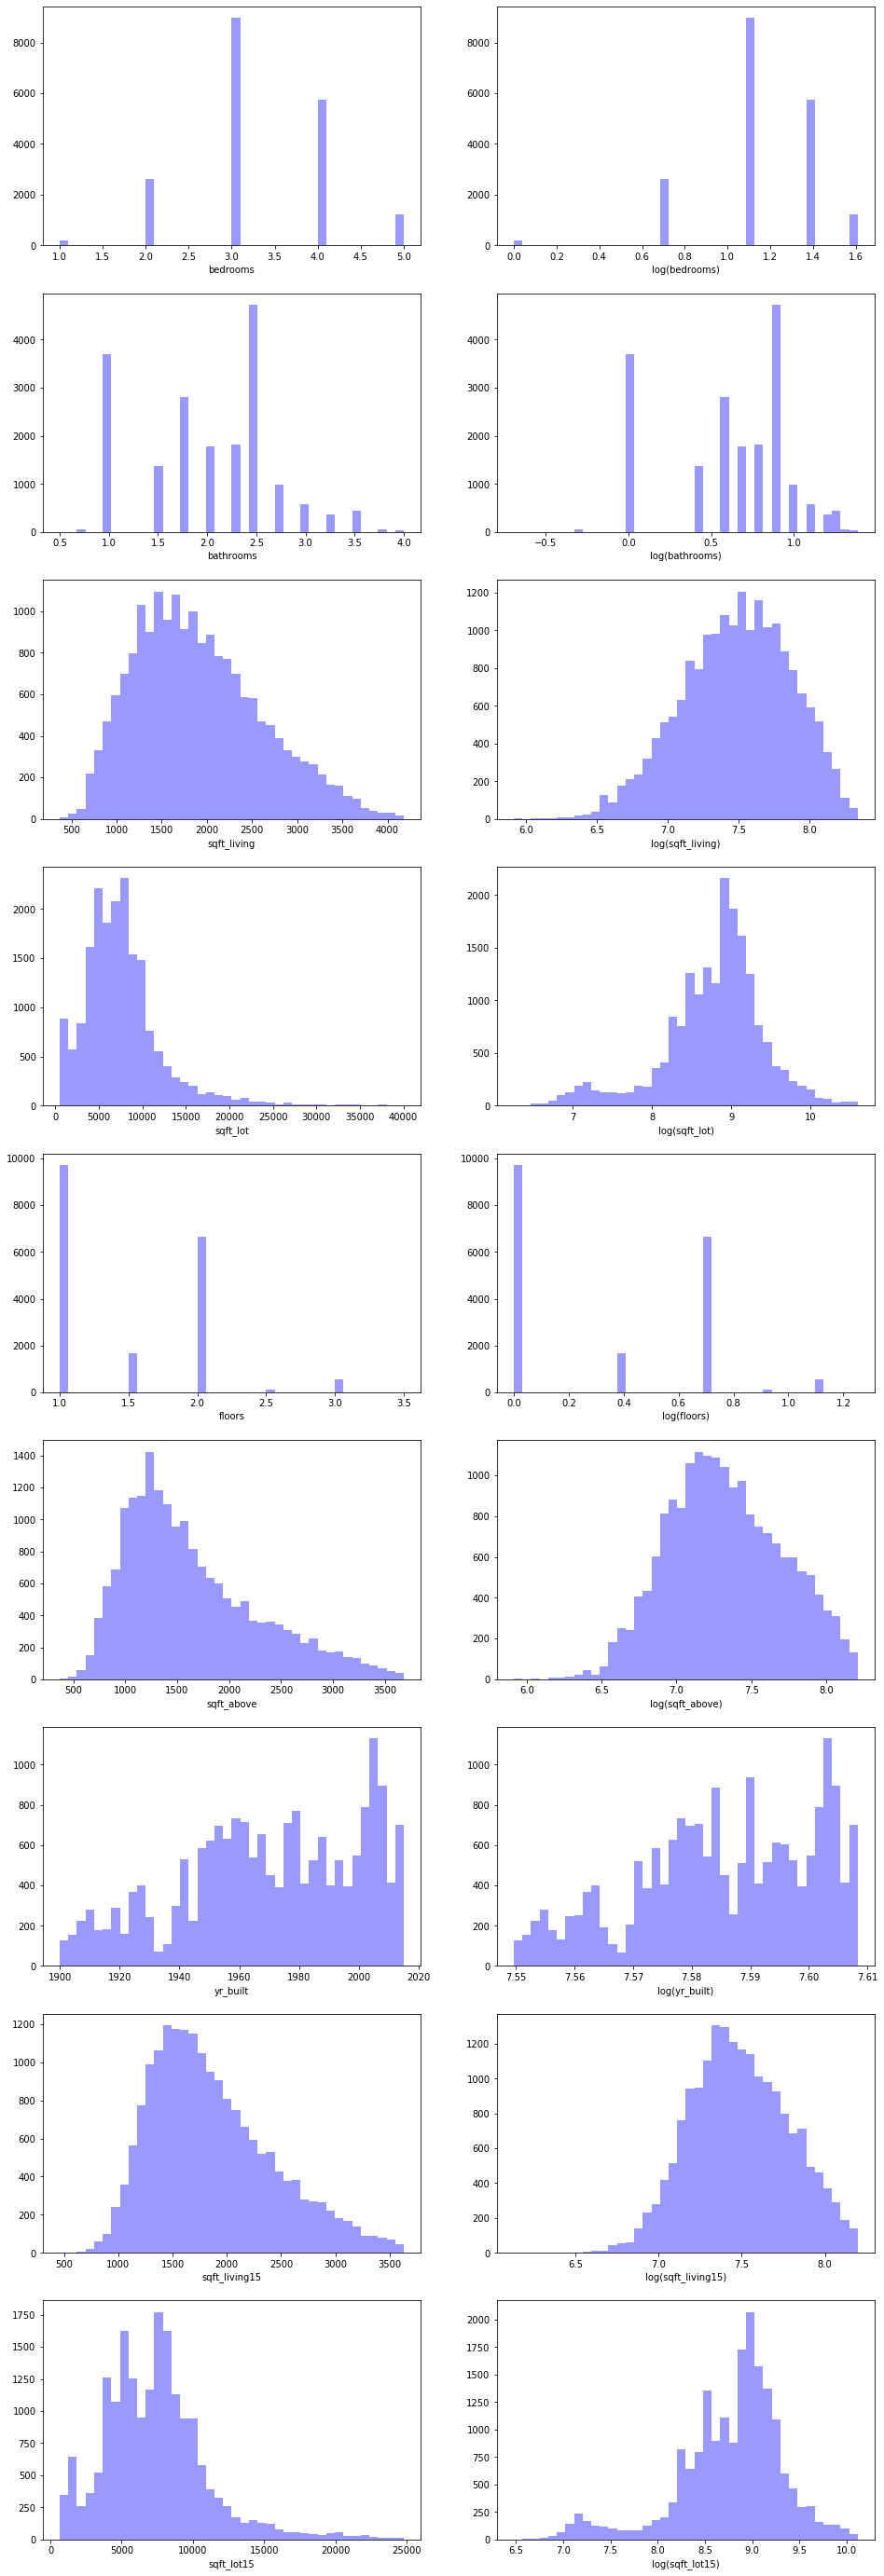

In [58]:
log_cols = [
    'bedrooms', 
    'bathrooms', 
    'sqft_living',
    'sqft_lot', 
    'floors',
    # 'waterfront', # Binary data, can't log zeroes and binary distribution isn't normal anyway
    # 'condition', # Categorical data doesn't make sense to log
    # 'grade', # Categorical data doesn't make sense to log
    'sqft_above',
    # 'sqft_basement', # Can't log because it has zero values
    'yr_built', 
    # 'zipcode', # Categorical data doesn't make sense to log
    # 'lat', # Not appropriate for lat
    # 'long', # Not appropriate for long, also can't log negative numbers
    'sqft_living15',
    'sqft_lot15'
       ]

fig, axes = plt.subplots(nrows=len(log_cols), ncols=2, figsize=(16, 50))
axes = list(axes.flatten())

for i, col in enumerate(log_cols):
    ax = axes.pop(0)
    log_ax = axes.pop(0)
    ax.set(xlabel=col)
    log_ax.set(xlabel=f'log({col})')
    ax.hist(df[col], bins=40, alpha=0.4, color='b', label=col)
    log_ax.hist(np.log(df[col]), bins=40, alpha=0.4, color='b', label=col)
plt.show()

The graphs show that many features would benefit from log-transforming them but some features, i.e. bedrooms, bathrooms, and floors, don't appear to be affected very much.

In [59]:
# Remove some features from the transform
log_cols.remove('bedrooms')
log_cols.remove('bathrooms')
log_cols.remove('floors')

# Log transform features
for col in log_cols:
    df[f'log_{col}'] = np.log(df[col])
    df.drop(col, axis=1, inplace=True)

# Scale features

Which features need to be scaled?

In [60]:
scale_cols = [
    # 'id', 
    # 'date', 
    # 'price', 
    'bedrooms', 
    'bathrooms', 
    'log_sqft_living',
    'log_sqft_lot', 
    'floors', 
    # 'waterfront', 
    # 'condition', 
    # 'grade', 
    'log_sqft_above',
    # 'yr_built', 
    # 'zipcode', 
    # 'lat', 
    # 'long',
    'log_sqft_living15',
    'log_sqft_lot15'
]

for col in scale_cols:
    df[f'scale_{col}'] = scale(df[col])
    df.drop(col, axis=1, inplace=True)

# Remove features that aren't statistically significant, stepwise feature selection

In [45]:
# y = df.price
# X = df.iloc[:, 1:]
# result = stepwise_selection(X, y, verbose=True)

Add  sqft_living                    with p-value 0.0
Add  grade                          with p-value 0.0
Add  view                           with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  lat                            with p-value 0.0
Add  waterfront                     with p-value 3.5825e-164
Add  condition                      with p-value 1.3572e-45
Add  floors                         with p-value 1.10441e-41
Add  sqft_living15                  with p-value 1.14797e-50
Add  sqft_lot15                     with p-value 1.45763e-36
Add  zipcode                        with p-value 7.75919e-33
Add  bedrooms                       with p-value 8.77974e-28
Add  bathrooms                      with p-value 7.91139e-28
Add  long                           with p-value 3.12148e-20
Add  renovated                      with p-value 8.69434e-15


In [61]:
y = df.price
X = df.iloc[:, 1:]
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                              4452.
Date:                Mon, 16 Mar 2020   Prob (F-statistic):                        0.00
Time:                        16:09:26   Log-Likelihood:                     -2.4537e+05
No. Observations:               18727   AIC:                                  4.909e+05
Df Residuals:                   18641   BIC:                                  4.916e+05
Df Model:                          86                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
waterfront               4.546e+05    1.5e+04     30.221      0.000    4.25e+05    4.84e+05
view                     6.174e+04   1497.158     41.240      0.000    5.88e+04    6.47e+04
condition                2.586e+04   1525.644     16.951      0.000    2.29e+04    2.89e+04
grade                    3.603e+04   2918.900     12.345      0.000    3.03e+04    4.18e+04
lat                     -4.417e+04   5.03e+04     -0.879      0.380   -1.43e+05    5.44e+04
long                    -2.039e+04   1.99e+04     -1.023      0.306   -5.94e+04    1.87e+04
has_basement             2.414e+04   3508.020      6.883      0.000    1.73e+04     3.1e+04
renovated                5.144e+04   5256.449      9.786      0.000    4.11e+04    6.17e+04
98002                    3.426e+04    1.1e+04      3.128      0.002    1.28e+04    5.57e+04
98003                    6603.1033   9851.131      0.670      0.503   -1.27e+04    2.59e+04
98004                    6.837e+05   1.96e+04     34.913      0.000    6.45e+05    7.22e+05
98005                    3.649e+05   2.09e+04     17.455      0.000    3.24e+05    4.06e+05
98006                    3.226e+05   1.74e+04     18.556      0.000    2.89e+05    3.57e+05
98007                    2.931e+05   2.16e+04     13.545      0.000    2.51e+05    3.35e+05
98008                    2.802e+05   2.08e+04     13.485      0.000    2.39e+05    3.21e+05
98010                    1.056e+05   1.82e+04      5.816      0.000       7e+04    1.41e+05
98011                    1.728e+05   2.62e+04      6.604      0.000    1.22e+05    2.24e+05
98014                    1.323e+05   3.17e+04      4.169      0.000    7.01e+04    1.94e+05
98019                      1.1e+05   2.98e+04      3.691      0.000    5.16e+04    1.68e+05
98022                    -299.6181   1.17e+04     -0.026      0.980   -2.32e+04    2.26e+04
98023                   -4604.1157   8763.360     -0.525      0.599   -2.18e+04    1.26e+04
98024                     1.86e+05   3.12e+04      5.962      0.000    1.25e+05    2.47e+05
98027                    2.779e+05   1.87e+04     14.870      0.000    2.41e+05    3.15e+05
98028                    1.604e+05   2.49e+04      6.450      0.000    1.12e+05    2.09e+05
98029                    2.803e+05   2.02e+04     13.862      0.000    2.41e+05     3.2e+05
98030                    1.276e+04    1.1e+04      1.157      0.247   -8855.260    3.44e+04
98031                     2.11e+04   1.17e+04      1.801      0.072   -1863.256    4.41e+04
98032                    2.574e+04   1.31e+04      1.968      0.049     103.808    5.14e+04
98033                    3.868e+05   2.22e+04     17.411      0.000    3.43e+05     4.3e+05
98034                    2.313e+05   2.3

# Detect interactions and deal with them

# Validate the model with k-fold cross validation

In [38]:
linreg = LinearRegression()
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_10_results

-17067436372.018183

# Pickle the model for portability

In [150]:
with open('regression_model.pickle', 'wb') as f:
    pickle.dump(model, f)

# Mapping the effect of zipcodes on price

Investigating lat/long feature to determine if I can use it as a predictor and how I should use it.

In [168]:
# Ingest shape file for King County zip codes
gdf = geopandas.read_file('./Zipcodes_for_King_County_and_Surrounding_Area__zipcode_area')

# Change zipcode to type int64
gdf.ZIPCODE = gdf.ZIPCODE.astype('int64')

# Process data for choropleth
map_df_zips = set([k for k in model.params.index if re.search('\d{4}', str(k))])
plot_zips = gdf.loc[gdf.ZIPCODE.map(lambda x: x in map_df_zips)]
plot_zips.set_index('ZIPCODE', inplace=True)
geojson_data = json.loads(plot_zips.to_json())
model_coef_data = {str(k): v for k, v in model.params.to_dict().items()}

# Colormap spec
colormap = linear.Reds_06.scale(-25214, 966723)

# Create layer
choro_layer = Choropleth(
    geo_data=geojson_data,
    choro_data=model_coef_data,
    colormap=colormap,
    border_color='black',
    style={'fillOpacity': 0.5}
)

# Create basemap, add choro_layer
m = Map(center=(47.5391,-122.070), zoom=9, basemap=basemaps.Esri.WorldTopoMap)
m.add_layer(choro_layer)

# Create html widget
html = HTML('''Hover over a zip_code''')
html.layout.margin = '0px 20px 20px 20px'
control = WidgetControl(widget=html, position='topright')
m.add_control(control)

# Function to handle hover event
def update_html(feature,  **kwargs):
    zipcode = int(feature['id'])
    html.value = f'''
    Zipcode: {zipcode}<br>
    Model Coefficient: {round(model.params.loc[zipcode], 3)}<br>
    N samples: {map_df.zipcode.value_counts().loc[zipcode]}
    '''
# Set on hover event listener
choro_layer.on_hover(update_html)

# display map
m

Map(center=[47.5391, -122.07], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…